In [1]:
import pandas as pd

In [20]:
df1 = pd.read_table("assignment/1.txt", header=None)
df2 = pd.read_table('assignment/2.txt', header=None)
df3 = pd.read_csv('assignment/3.txt')

C:\ProgramData\Miniconda3\envs\pygpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Miniconda3\envs\pygpu\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [32]:
df1.columns = ['Text', 'Prediction']
df2.columns = ['Prediction', 'Text']
df2 = df2[['Text', 'Prediction']]

In [36]:
print(df1.head())
print(df1.shape)

                                                Text  Prediction
0  A very, very, very slow-moving, aimless movie ...           0
1  Not sure who was more lost - the flat characte...           0
2  Attempting artiness with black & white and cle...           0
3       Very little music or anything to speak of.             0
4  The best scene in the movie was when Gerardo i...           1
(700, 2)


In [37]:
print(df2.head())
print(df2.shape)

                                                Text  Prediction
0            The Da Vinci Code book is just awesome.           1
1  this was the first clive cussler i've ever rea...           1
2                   i liked the Da Vinci Code a lot.           1
3                   i liked the Da Vinci Code a lot.           1
4  I liked the Da Vinci Code but it ultimatly did...           1
(6918, 2)


In [38]:
print(df3.head())
print(df3.shape)

   Unnamed: 0  index                                               Text  \
0           0      0  I exchanged the sony ericson z500a for this an...   
1           1      1  Oh and I forgot to also mention the weird colo...   
2           2      2  Verizon tech support walked my through a few p...   
3           3      3                          Better than you'd expect.   
4           4      4                       This is a great little item.   

   Prediction  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
(932, 4)


In [39]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [56]:
train_df = df1.append(df2, ignore_index=True)
test_df = df3[['Text', 'Prediction']]

In [58]:
test_df.shape

(932, 2)

In [46]:
train_df.shape

(7618, 2)

In [48]:
## target count ##
cnt_srs = train_df['Prediction'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

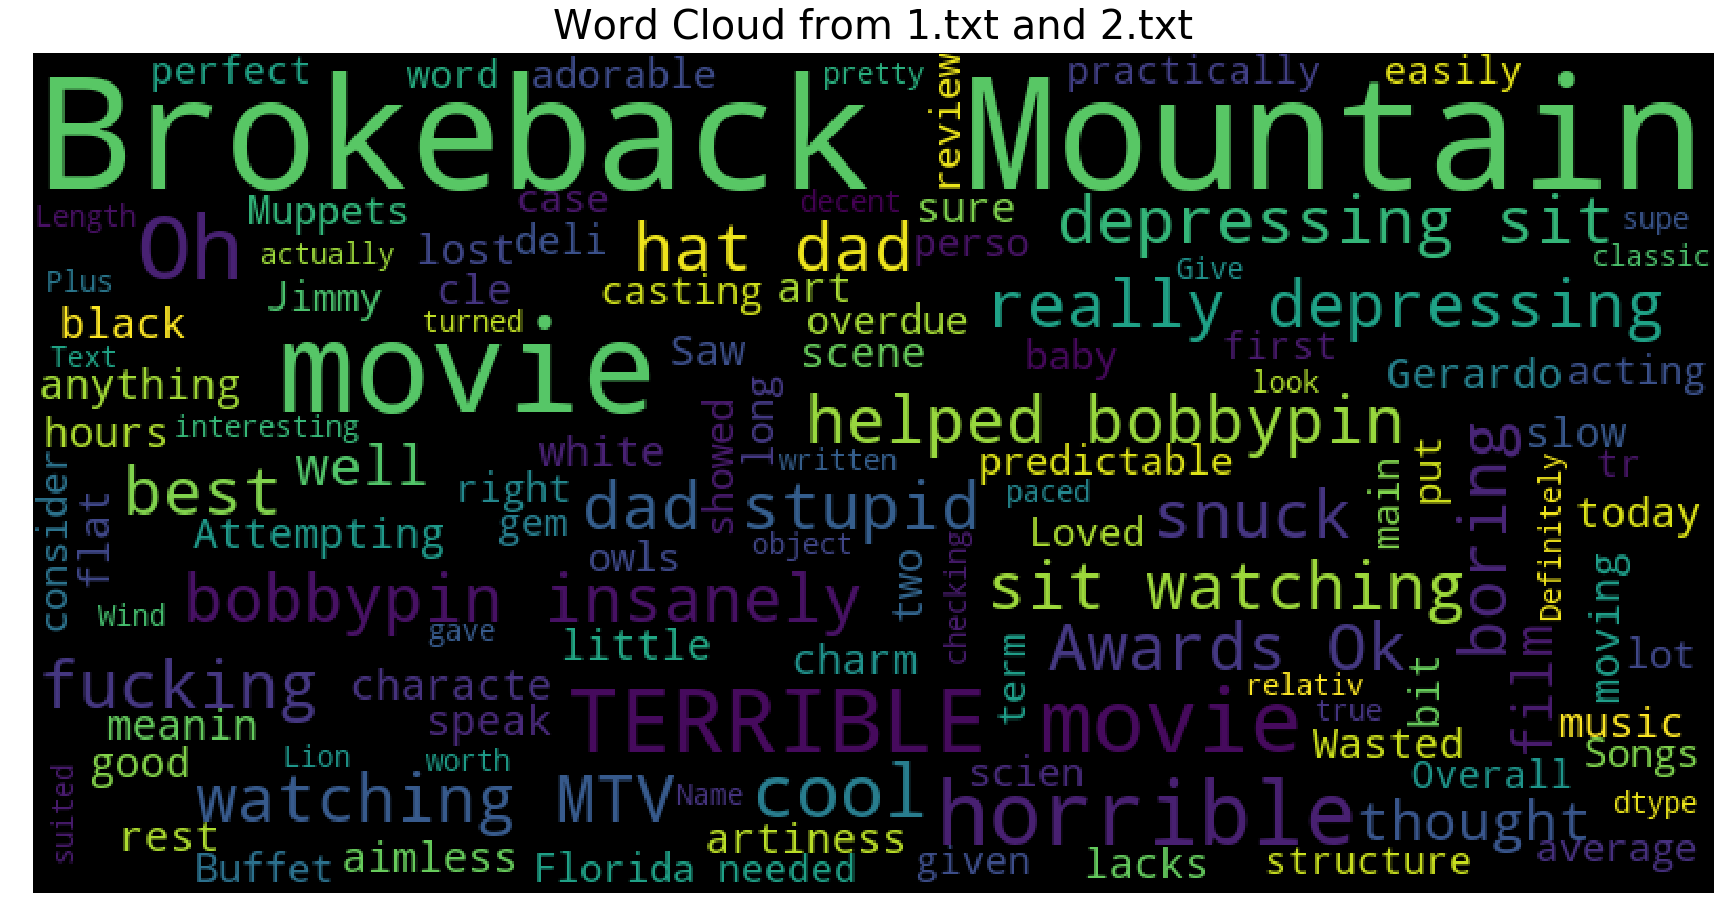

In [50]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["Text"], title="Word Cloud from 1.txt and 2.txt")

In [53]:
from collections import defaultdict
train1_df = train_df[train_df["Prediction"]==1]
train0_df = train_df[train_df["Prediction"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["Text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["Text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [54]:
freq_dict = defaultdict(int)
for sent in train0_df["Text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["Text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [55]:
freq_dict = defaultdict(int)
for sent in train0_df["Text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["Text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [59]:
train_df["num_words"] = train_df["Text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["Text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["Text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["Text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["Text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["Text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["Text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["Text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["Text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["Text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["Text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["Text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [62]:
#Baseline Model

# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train_df['Text'].values.tolist() + test_df['Text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Text'].values.tolist())

In [63]:
train_y = train_df["Prediction"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


In [69]:
for thresh in np.arange(0.4, 0.601, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

F1 score at threshold 0.4 is 0.9619101762364979
F1 score at threshold 0.41 is 0.9641025641025641
F1 score at threshold 0.42 is 0.9646522234891676
F1 score at threshold 0.43 is 0.9651229273870784
F1 score at threshold 0.44 is 0.9667812142038945
F1 score at threshold 0.45 is 0.9684089603676048
F1 score at threshold 0.46 is 0.9694876223373633
F1 score at threshold 0.47 is 0.9700460829493088
F1 score at threshold 0.48 is 0.9722222222222223
F1 score at threshold 0.49 is 0.9727851766068327
F1 score at threshold 0.5 is 0.972594752186589
F1 score at threshold 0.51 is 0.9747800586510263
F1 score at threshold 0.52 is 0.9729411764705882
F1 score at threshold 0.53 is 0.9716646989374262
F1 score at threshold 0.54 is 0.970344009489917
F1 score at threshold 0.55 is 0.9708506841165973
F1 score at threshold 0.56 is 0.9712918660287081
F1 score at threshold 0.57 is 0.968129885748647
F1 score at threshold 0.58 is 0.9668074834037417
F1 score at threshold 0.59 is 0.9655589123867071
F1 score at threshold 0.6

In [70]:
#f1 score is best at 0.51

In [73]:
import eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+9.769,awesome
+9.503,love
+5.645,loved
+5.057,beautiful
+5.013,like
+3.717,love brokeback
+3.717,love brokeback mountain
+3.691,liked
+3.155,love harry
+3.155,love harry potter
